# R scripts for fate tracking and/or metadata analysis 

In [12]:
library(tidyverse)
library(vegan)
library(phyloseq)
library(dplyr)
library(ggplot2)
library(stringr)

In [13]:
setwd('/project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/metadata')

In [14]:
getwd()

[1] "/project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/metadata"

In [15]:
colony_data <- read.csv('CBC_ColonyData.csv')

In [16]:
colony_data <- colony_data[, -1]

In [17]:
# extract year from Date_InitialTag and add it to new column
colony_data$Year_tagged <- format(as.Date(colony_data$Date_InitialTag, format="%m/%d/%y"), "%Y")

In [18]:
head(colony_data)

,Date_InitialTag,Transect,TransectNum,OldTagNum,NewTagNum,Species,Meter,Meters_90,Direction,Size_Class,⋯,Height,Date_DocumentedDisease,Date_DocumentedMortality,Notes_May2022,Sept_2023,Nov_2023,Dec_2023,Jan_2024,Feb_2024,Year_tagged
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<int>,⋯,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,6/21/19,CBC30N,1,349,1,SSID,1.5,0.50,right,5,⋯,24,5/21/22,Diseased,NA,,Not Visited,Not Visited,,Not visited,2019
2,6/21/19,CBC30N,1,334,2,PAST,1.4,0.10,left,4,⋯,8,Healthy,Healthy,NA,90%Pale,100% Bleached,100% Bleached,Dead,"NOT dead- 90% mortality, too small for immune sample",2019
3,6/21/19,CBC30N,1,346,3,SSID,6.3,0.80,right,5,⋯,30,5/21/22,Diseased,NA,"80^Pale, 80% discoloration","95% Pale, 5% Bleached",80% CLP,,98% bleached,2019
4,10/15/19,CBC30N,1,407,4,PSTR,6.5,0.50,right,3,⋯,39,5/21/22,12/2/22,NA,,NA,NA,,Not visited,2019
5,6/24/19,CBC30N,1,394,5,SSID,4.3,1.20,left,5,⋯,27,5/21/22,Diseased,NA,,Not Visited,Not Visited,,Not visited,2019
6,10/15/19,CBC30N,1,413,6,PSTR,8.3,1.75,left,NA,⋯,38,12/2/22,9/25/23,NA,Dead,Not Visited,Not Visited,,Not visited,2019


In [19]:
nrow(colony_data)

[1] 186

## Changing Data Organization 

In [20]:
# Messing with reorganization to fully capture picture and timeline of disease and bleaching trajectory 
# Goal is to have 2 columns per date: MY_condition & MY_percentage (& probably date_notes col too)
# Using MonthYear format for date to keep consistent with sample labels 
# Percentage Notes: NA for healthy for now
# Condition Notes: put multiple conditions in the same colony if necessary, seperate by _

In [21]:
# getting subset so df is smaller to work with
#colony_conditions <- subset(colony_data, select = -c(Transect, OldTagNum, NewTagNum, Meter, Meters_90, Direction, MaxDiameter, Height))

# after manipulating data, need the entire df before downloading 
colony_conditions <- colony_data

In [22]:
head(colony_conditions)

,Date_InitialTag,Transect,TransectNum,OldTagNum,NewTagNum,Species,Meter,Meters_90,Direction,Size_Class,⋯,Height,Date_DocumentedDisease,Date_DocumentedMortality,Notes_May2022,Sept_2023,Nov_2023,Dec_2023,Jan_2024,Feb_2024,Year_tagged
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<int>,⋯,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,6/21/19,CBC30N,1,349,1,SSID,1.5,0.50,right,5,⋯,24,5/21/22,Diseased,NA,,Not Visited,Not Visited,,Not visited,2019
2,6/21/19,CBC30N,1,334,2,PAST,1.4,0.10,left,4,⋯,8,Healthy,Healthy,NA,90%Pale,100% Bleached,100% Bleached,Dead,"NOT dead- 90% mortality, too small for immune sample",2019
3,6/21/19,CBC30N,1,346,3,SSID,6.3,0.80,right,5,⋯,30,5/21/22,Diseased,NA,"80^Pale, 80% discoloration","95% Pale, 5% Bleached",80% CLP,,98% bleached,2019
4,10/15/19,CBC30N,1,407,4,PSTR,6.5,0.50,right,3,⋯,39,5/21/22,12/2/22,NA,,NA,NA,,Not visited,2019
5,6/24/19,CBC30N,1,394,5,SSID,4.3,1.20,left,5,⋯,27,5/21/22,Diseased,NA,,Not Visited,Not Visited,,Not visited,2019
6,10/15/19,CBC30N,1,413,6,PSTR,8.3,1.75,left,NA,⋯,38,12/2/22,9/25/23,NA,Dead,Not Visited,Not Visited,,Not visited,2019


In [46]:
colnames(colony_data)

[1] "Date_InitialTag"          "Transect"                
 [3] "TransectNum"              "OldTagNum"               
 [5] "NewTagNum"                "Species"                 
 [7] "Meter"                    "Meters_90"               
 [9] "Direction"                "Size_Class"              
[11] "Notes_June_2019"          "MaxDiameter"             
[13] "Height"                   "Date_DocumentedDisease"  
[15] "Date_DocumentedMortality" "Notes_May2022"           
[17] "Sept_2023"                "Nov_2023"                
[19] "Dec_2023"                 "Jan_2024"                
[21] "Feb_2024"                 "Year_tagged"

In [23]:
# Add 2019_Coniditon and 2019_Percentage columns 
# If year tagged = 2019, "Healthy" in condition, NA in percentage
# If year tagged != 2019, NA for both
colony_conditions <- colony_conditions %>%
  mutate(`062019_Condition` = if_else(Year_tagged == 2019, "Healthy", NA_character_),
         `062019_Percentage` = NA_real_)

In [24]:
# Add 052022_Condition and 052022_Percentage columns 

# Look at DateDisease and DateMortality columns..if there's a may 2022 in either, add that condition, leave percentage blank for now
# If "Healthy" in datedisease, add healthy to condition 
# If year tagged != 2019 or 2022, NA for both

#establish pattern that selects colonies that got disease in May 2022
may_pattern <- grepl("5/\\d{1,2}/22", colony_conditions$Date_DocumentedDisease, fixed = FALSE)
may_dead_pattern <- grepl("5/\\d{1,2}/22", colony_conditions$Date_DocumentedMortality, fixed = FALSE)
tagged_may2022 <- grepl("5/\\d{1,2}/22", colony_conditions$Date_InitialTag, fixed = FALSE)
      
colony_conditions <- colony_conditions %>%
  mutate(`052022_Condition` =
           case_when(
             may_dead_pattern ~ "Dead",
             may_pattern ~ "Diseased",
             tagged_may2022 ~ "Healthy",
             TRUE ~ `062019_Condition`)  # Use 062019_Condition if none of the above conditions match
         )
#casewhen evaluates in order

In [25]:
# Add 122022_Condition and 122022_Percentage columns 

#establish pattern that selects colonies that got disease/died in Dec 2022
dec_pattern <- grepl("12/\\d{1,2}/22", colony_conditions$Date_DocumentedDisease, fixed = FALSE)
dec_dead_pattern <- grepl("12/\\d{1,2}/22", colony_conditions$Date_DocumentedMortality, fixed = FALSE)
tagged_dec2022 <- grepl("12/\\d{1,2}/22", colony_conditions$Date_InitialTag, fixed = FALSE)
      
colony_conditions <- colony_conditions %>%
  mutate(`122022_Condition` =
           case_when(
             dec_dead_pattern ~ "Dead",
               dec_pattern ~ "Diseased",
               tagged_dec2022 ~ "Healthy",
             TRUE ~ `052022_Condition`)  # Use 052022_Condition if none of the above conditions match
         )

In [26]:
# Add 2023_Condition and 2023_Percentage columns  

#establish pattern that selects colonies that got disease/died in 2023
may2023_pattern <- grepl("5/\\d{1,2}/23", colony_conditions$Date_DocumentedDisease, fixed = FALSE)
may2023_dead_pattern <- grepl("5/\\d{1,2}/23", colony_conditions$Date_DocumentedMortality, fixed = FALSE)

colony_conditions <- colony_conditions %>%
  mutate(
    `052023_Condition` = case_when(
      may2023_dead_pattern ~ "Dead",
      may2023_pattern ~ "Diseased",
      TRUE ~ `122022_Condition`
    )
  ) 

In [27]:
head(colony_conditions)

,Date_InitialTag,Transect,TransectNum,OldTagNum,NewTagNum,Species,Meter,Meters_90,Direction,Size_Class,⋯,Nov_2023,Dec_2023,Jan_2024,Feb_2024,Year_tagged,062019_Condition,062019_Percentage,052022_Condition,122022_Condition,052023_Condition
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<int>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
1,6/21/19,CBC30N,1,349,1,SSID,1.5,0.50,right,5,⋯,Not Visited,Not Visited,,Not visited,2019,Healthy,NA,Diseased,Diseased,Diseased
2,6/21/19,CBC30N,1,334,2,PAST,1.4,0.10,left,4,⋯,100% Bleached,100% Bleached,Dead,"NOT dead- 90% mortality, too small for immune sample",2019,Healthy,NA,Healthy,Healthy,Healthy
3,6/21/19,CBC30N,1,346,3,SSID,6.3,0.80,right,5,⋯,"95% Pale, 5% Bleached",80% CLP,,98% bleached,2019,Healthy,NA,Diseased,Diseased,Diseased
4,10/15/19,CBC30N,1,407,4,PSTR,6.5,0.50,right,3,⋯,NA,NA,,Not visited,2019,Healthy,NA,Diseased,Dead,Dead
5,6/24/19,CBC30N,1,394,5,SSID,4.3,1.20,left,5,⋯,Not Visited,Not Visited,,Not visited,2019,Healthy,NA,Diseased,Diseased,Diseased
6,10/15/19,CBC30N,1,413,6,PSTR,8.3,1.75,left,NA,⋯,Not Visited,Not Visited,,Not visited,2019,Healthy,NA,Healthy,Diseased,Diseased


In [28]:
# sep 2023 is when bleaching tracking begins: take bleaching notes and incorporate into conditions 
colony_conditions_2023 <- colony_conditions %>%
rowwise() %>% 
  mutate(
    `092023_Condition` = case_when(
      str_detect(Sept_2023, "(?i)Pale") & str_detect(Sept_2023, "(?i)Bleach") & str_detect(Sept_2023, "(?i)Discolor") ~ "CLP,CLB,CLD",
        str_detect(Sept_2023, "(?i)Pale") & str_detect(Sept_2023, "(?i)Discolor") ~ "CLP,CLD",
        str_detect(Sept_2023, "(?i)Pale") & str_detect(Sept_2023, "(?i)Bleach") ~ "CLP,CLB",
        str_detect(Sept_2023, "(?i)Discolor")& str_detect(Sept_2023, "(?i)Bleach") ~ "CLB,CLD",
        str_detect(Sept_2023, "(?i)Pale") ~ "CLP",
        str_detect(Sept_2023, "(?i)Discolor") ~ "CLD",
        str_detect(Sept_2023, "(?i)Bleach") ~ "CLB",
        grepl("9/\\d{1,2}/23", Date_DocumentedDisease, fixed = FALSE) ~ "Diseased",
        grepl("9/\\d{1,2}/23", Date_DocumentedMortality, fixed = FALSE) ~ "Dead",
        TRUE ~ `052023_Condition`)
      )
        

rows<- colony_conditions_2023$Year_tagged == '2019'
head(colony_conditions_2023[rows,c("Date_DocumentedDisease","Date_DocumentedMortality","Sept_2023", "052023_Condition", "092023_Condition")])

Date_DocumentedDisease,Date_DocumentedMortality,Sept_2023,052023_Condition,092023_Condition
<chr>,<chr>,<chr>,<chr>,<chr>
5/21/22,Diseased,,Diseased,Diseased
Healthy,Healthy,90%Pale,Healthy,CLP
5/21/22,Diseased,"80^Pale, 80% discoloration",Diseased,"CLP,CLD"
5/21/22,12/2/22,,Dead,Dead
5/21/22,Diseased,,Diseased,Diseased
12/2/22,9/25/23,Dead,Diseased,Dead


In [29]:
colony_conditions_2023$Sept_2023 <-str_replace(colony_conditions_2023$Sept_2023, "\\^", "%")
colnames(colony_conditions_2023)

[1] "Date_InitialTag"          "Transect"                
 [3] "TransectNum"              "OldTagNum"               
 [5] "NewTagNum"                "Species"                 
 [7] "Meter"                    "Meters_90"               
 [9] "Direction"                "Size_Class"              
[11] "Notes_June_2019"          "MaxDiameter"             
[13] "Height"                   "Date_DocumentedDisease"  
[15] "Date_DocumentedMortality" "Notes_May2022"           
[17] "Sept_2023"                "Nov_2023"                
[19] "Dec_2023"                 "Jan_2024"                
[21] "Feb_2024"                 "Year_tagged"             
[23] "062019_Condition"         "062019_Percentage"       
[25] "052022_Condition"         "122022_Condition"        
[27] "052023_Condition"         "092023_Condition"

In [30]:
#make percentage column 092023_Percentage
colony_conditions_2023 <- colony_conditions_2023 %>%
  rowwise() %>% 
  mutate(
    `092023_Percentage` = ifelse(!is.na(Sept_2023), {
      percentages <- str_extract_all(Sept_2023, "\\b\\d+%")[[1]]
      reversed_percentages <- rev(percentages)
      paste(reversed_percentages, collapse = ",")
    }, "")
  )
rows<- colony_conditions_2023$Year_tagged == '2019'
colony_conditions_2023[rows,c("Date_DocumentedDisease","Date_DocumentedMortality","Sept_2023", "052023_Condition", "092023_Condition","092023_Percentage")]


Date_DocumentedDisease,Date_DocumentedMortality,Sept_2023,052023_Condition,092023_Condition,092023_Percentage
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
5/21/22,Diseased,,Diseased,Diseased,
Healthy,Healthy,90%Pale,Healthy,CLP,90%
5/21/22,Diseased,"80%Pale, 80% discoloration",Diseased,"CLP,CLD","80%,80%"
5/21/22,12/2/22,,Dead,Dead,
5/21/22,Diseased,,Diseased,Diseased,
12/2/22,9/25/23,Dead,Diseased,Dead,
Healthy,Healthy,,Healthy,Healthy,
5/21/22,9/25/23,Dead,Diseased,Dead,
5/21/22,Diseased,,Diseased,Diseased,


In [31]:
colony_conditions_2023[colony_conditions_2023$'092023_Percentage' != "",c("Sept_2023","092023_Condition","092023_Percentage")]

#test<-grepl("70",colony_conditions_2023$Sept_2023)
#colony_conditions_2023[test,c("Sept_2023","092023_Condition","092023_Percentage")]

Sept_2023,092023_Condition,092023_Percentage
<chr>,<chr>,<chr>
90%Pale,CLP,90%
"80%Pale, 80% discoloration","CLP,CLD","80%,80%"
10%Pale,CLP,10%
100%Pale,CLP,100%
100% Pale,CLP,100%
"100% Bleached, Sampled as Diseased",CLB,100%
"100% Bleached, Sampled as Diseased",CLB,100%
90%Pale,CLP,90%
"70%Bleach, 20% Pale","CLP,CLB","20%,70%"


In [32]:
colnames(colony_conditions_2023)


[1] "Date_InitialTag"          "Transect"                
 [3] "TransectNum"              "OldTagNum"               
 [5] "NewTagNum"                "Species"                 
 [7] "Meter"                    "Meters_90"               
 [9] "Direction"                "Size_Class"              
[11] "Notes_June_2019"          "MaxDiameter"             
[13] "Height"                   "Date_DocumentedDisease"  
[15] "Date_DocumentedMortality" "Notes_May2022"           
[17] "Sept_2023"                "Nov_2023"                
[19] "Dec_2023"                 "Jan_2024"                
[21] "Feb_2024"                 "Year_tagged"             
[23] "062019_Condition"         "062019_Percentage"       
[25] "052022_Condition"         "122022_Condition"        
[27] "052023_Condition"         "092023_Condition"        
[29] "092023_Percentage"

In [33]:
# make condition and percentage cols for Nov_2023
colony_conditions_2023 <- colony_conditions_2023 %>%
rowwise() %>% 
  mutate(
    `112023_Condition` = case_when(
      str_detect(Nov_2023, "(?i)Pale") & str_detect(Nov_2023, "(?i)Bleach") & str_detect(Nov_2023, "(?i)Discolor") ~ "CLP,CLD,CLB",
        str_detect(Nov_2023, "(?i)Pale") & str_detect(Nov_2023, "(?i)Discolor") ~ "CLP,CLD",
        str_detect(Nov_2023, "(?i)Pale") & str_detect(Nov_2023, "(?i)Bleach") ~ "CLP,CLB",
        str_detect(Nov_2023, "(?i)Discolor")& str_detect(Nov_2023, "(?i)Bleach") ~ "CLB,CLD",
        str_detect(Nov_2023, "(?i)Pale") ~ "CLP",
        str_detect(Nov_2023, "(?i)Discolor") ~ "CLD",
        str_detect(Nov_2023, "(?i)Bleach") ~ "CLB",
        grepl("11/\\d{1,2}/23", Date_DocumentedDisease, fixed = FALSE) ~ "Diseased",
        grepl("11/\\d{1,2}/23", Date_DocumentedMortality, fixed = FALSE) ~ "Dead",
        TRUE ~ `092023_Condition`)
      )

#make percentage column
colony_conditions_2023 <- colony_conditions_2023 %>%
  rowwise() %>% 
  mutate(
    `112023_Percentage` = ifelse(!is.na(Nov_2023), {
      percentages <- str_extract_all(Nov_2023, "\\b\\d+%")[[1]]
      reversed_percentages <- rev(percentages)
      paste(reversed_percentages, collapse = ",")
    }, "")
  )

head(colony_conditions_2023[, c("Date_DocumentedDisease", "Date_DocumentedMortality", "Sept_2023","Nov_2023", "052023_Condition", "092023_Condition", "112023_Condition","112023_Percentage")])
colony_conditions_2023[colony_conditions_2023$'112023_Percentage' != "",c("Nov_2023","112023_Condition","112023_Percentage")]


Date_DocumentedDisease,Date_DocumentedMortality,Sept_2023,Nov_2023,052023_Condition,092023_Condition,112023_Condition,112023_Percentage
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
5/21/22,Diseased,,Not Visited,Diseased,Diseased,Diseased,
Healthy,Healthy,90%Pale,100% Bleached,Healthy,CLP,CLB,100%
5/21/22,Diseased,"80%Pale, 80% discoloration","95% Pale, 5% Bleached",Diseased,"CLP,CLD","CLP,CLB","5%,95%"
5/21/22,12/2/22,,NA,Dead,Dead,Dead,
5/21/22,Diseased,,Not Visited,Diseased,Diseased,Diseased,
12/2/22,9/25/23,Dead,Not Visited,Diseased,Dead,Dead,


Nov_2023,112023_Condition,112023_Percentage
<chr>,<chr>,<chr>
100% Bleached,CLB,100%
"95% Pale, 5% Bleached","CLP,CLB","5%,95%"
100% Pale,CLP,100%
98% Mortality,Healthy,98%
100% Pale,CLP,100%
100% Bleached,CLB,100%
5% Bleached,CLB,5%
90% Bleached,CLB,90%
100% Pale,CLP,100%


In [34]:
cols_to_look <- c('Notes_June_2019', 'Notes_May2022', 'Sept_2023', 'Nov_2023', 'Dec_2023', 'Jan_2024', 'Feb_2024')
#colony_conditions_2023[,cols_to_look]
rows_mortality<-str_detect(colony_conditions_2023[,cols_to_look], "Mortality|TL")
#colony_conditions_2023[rows_mortality,]

Warning message in stri_detect_regex(string, pattern, negate = negate, opts_regex = opts(pattern)):
“argument is not an atomic vector; coercing”


In [35]:
find <- str_detect(colony_conditions_2023$Nov_2023, "Mortality|TL")
colony_conditions_2023[find, "Nov_2023"]

Nov_2023
<chr>
NA
NA
NA
98% Mortality
NA
NA
NA
NA
NA


In [36]:
# make condition and percentage cols for Nov_2023
colony_conditions_2023 <- colony_conditions_2023 %>%
rowwise() %>% 
  mutate(
    `122023_Condition` = case_when(
      str_detect(Dec_2023, "(?i)Pale|CLP") & str_detect(Dec_2023, "(?i)Bleach|CLB") & str_detect(Dec_2023, "(?i)Discolor|CLD") ~ "CLP,CLD,CLB",
        str_detect(Dec_2023, "(?i)Pale|CLP") & str_detect(Dec_2023, "(?i)Discolor|CLD") ~ "CLP,CLD",
        str_detect(Dec_2023, "(?i)Pale|CLP|Paling") & str_detect(Dec_2023, "(?i)Bleach|CLB") ~ "CLP,CLB",
        str_detect(Dec_2023, "(?i)Discolor|CLD")& str_detect(Dec_2023, "(?i)Bleach|CLB") ~ "CLB,CLD",
        str_detect(Dec_2023, "(?i)Pale|CLP|Paling") ~ "CLP",
        str_detect(Dec_2023, "(?i)Discolor|CLD") ~ "CLD",
        str_detect(Dec_2023, "(?i)Bleach|CLB") ~ "CLB",
        grepl("12/\\d{1,2}/23", Date_DocumentedDisease, fixed = FALSE) ~ "Diseased",
        grepl("12/\\d{1,2}/23", Date_DocumentedMortality, fixed = FALSE) ~ "Dead",
        TRUE ~ `112023_Condition`)
      )

#make percentage column
colony_conditions_2023 <- colony_conditions_2023 %>%
  rowwise() %>% 
  mutate(
    `122023_Percentage` = ifelse(!is.na(Dec_2023), {
      percentages <- str_extract_all(Dec_2023, "\\b\\d+%")[[1]]
      reversed_percentages <- rev(percentages)
      paste(reversed_percentages, collapse = ",")
    }, "")
  )

head(colony_conditions_2023[, c("Date_DocumentedDisease", "Date_DocumentedMortality","Nov_2023", "Dec_2023", "112023_Condition","112023_Percentage","122023_Condition","122023_Percentage" )])
Dec2023_conditions<- colony_conditions_2023[colony_conditions_2023$'122023_Percentage' != "",c("Dec_2023","122023_Condition","122023_Percentage")]


Date_DocumentedDisease,Date_DocumentedMortality,Nov_2023,Dec_2023,112023_Condition,112023_Percentage,122023_Condition,122023_Percentage
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
5/21/22,Diseased,Not Visited,Not Visited,Diseased,,Diseased,
Healthy,Healthy,100% Bleached,100% Bleached,CLB,100%,CLB,100%
5/21/22,Diseased,"95% Pale, 5% Bleached",80% CLP,"CLP,CLB","5%,95%",CLP,80%
5/21/22,12/2/22,NA,NA,Dead,,Dead,
5/21/22,Diseased,Not Visited,Not Visited,Diseased,,Diseased,
12/2/22,9/25/23,Not Visited,Not Visited,Dead,,Dead,


In [37]:
rows_to_look_at<-str_detect(Dec2023_conditions$Dec_2023, "Mortality|TL")
Dec2023_conditions$`122023_Percentage`[rows_to_look_at] <- c("20%", "100%", "100%")
Dec2023_conditions[rows_to_look_at,]

Dec_2023,122023_Condition,122023_Percentage
<chr>,<chr>,<chr>
"20% CLP, 10% TL",CLP,20%
"90% Mortality, 100% CLB",CLB,100%
"75% Mortality, 100%CLB",CLB,100%


In [38]:
# make condition and percentage cols for Nov_2023
colony_conditions_2023 <- colony_conditions_2023 %>%
rowwise() %>% 
  mutate(
    `012024_Condition` = case_when(
      str_detect(Jan_2024, "(?i)Pale|CLP") & str_detect(Jan_2024, "(?i)Bleach|CLB") & str_detect(Jan_2024, "(?i)Discolor|CLD") ~ "CLP,CLD,CLB",
        str_detect(Jan_2024, "(?i)Pale|CLP") & str_detect(Jan_2024, "(?i)Discolor|CLD") ~ "CLP,CLD",
        str_detect(Jan_2024, "(?i)Pale|CLP|Paling") & str_detect(Jan_2024, "(?i)Bleach|CLB") ~ "CLP,CLB",
        str_detect(Jan_2024, "(?i)Discolor|CLD")& str_detect(Jan_2024, "(?i)Bleach|CLB") ~ "CLB,CLD",
        str_detect(Jan_2024, "(?i)Pale|CLP|Paling") ~ "CLP",
        str_detect(Jan_2024, "(?i)Discolor|CLD") ~ "CLD",
        str_detect(Jan_2024, "(?i)Bleach|CLB") ~ "CLB",
        grepl("1/\\d{1,2}/24", Date_DocumentedDisease, fixed = FALSE) ~ "Diseased",
        grepl("1/\\d{1,2}/24", Date_DocumentedMortality, fixed = FALSE) ~ "Dead",
        TRUE ~ `122023_Condition`)
      )

#make percentage column
colony_conditions_2023 <- colony_conditions_2023 %>%
  rowwise() %>% 
  mutate(
    `012024_Percentage` = ifelse(!is.na(Jan_2024), {
      percentages <- str_extract_all(Jan_2024, "\\b\\d+%")[[1]]
      reversed_percentages <- rev(percentages)
      paste(reversed_percentages, collapse = ",")
    }, "")
  )

head(colony_conditions_2023[, c("Date_DocumentedDisease", "Date_DocumentedMortality","Dec_2023", "Jan_2024","122023_Condition","122023_Percentage", "012024_Condition", "012024_Percentage" )])
colony_conditions_2023[colony_conditions_2023$'012024_Percentage' != "",c("Jan_2024","012024_Condition","012024_Percentage")]


Date_DocumentedDisease,Date_DocumentedMortality,Dec_2023,Jan_2024,122023_Condition,122023_Percentage,012024_Condition,012024_Percentage
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
5/21/22,Diseased,Not Visited,,Diseased,,Diseased,
Healthy,Healthy,100% Bleached,Dead,CLB,100%,CLB,
5/21/22,Diseased,80% CLP,,CLP,80%,CLP,
5/21/22,12/2/22,NA,,Dead,,Dead,
5/21/22,Diseased,Not Visited,,Diseased,,Diseased,
12/2/22,9/25/23,Not Visited,,Dead,,Dead,


Jan_2024,012024_Condition,012024_Percentage
<chr>,<chr>,<chr>
60% Bleached,CLB,60%
85% Bleached,CLB,85%
20% Bleached,CLB,20%
10%TL,CLP,10%
5% CLP,CLP,5%
10% Bleaching,CLB,10%
5% CLP,CLP,5%
"5% CLP, damsel predation",CLP,5%
1% CLP,CLP,1%


In [39]:
# make condition and percentage cols for Nov_2023
colony_conditions_2023 <- colony_conditions_2023 %>%
rowwise() %>% 
  mutate(
    `022024_Condition` = case_when(
      str_detect(Feb_2024, "(?i)Pale|CLP") & str_detect(Feb_2024, "(?i)Bleach|CLB") & str_detect(Feb_2024, "(?i)Discolor|CLD") ~ "CLP,CLD,CLB",
        str_detect(Feb_2024, "(?i)Pale|CLP") & str_detect(Feb_2024, "(?i)Discolor|CLD") ~ "CLP,CLD",
        str_detect(Feb_2024, "(?i)Pale|CLP|Paling") & str_detect(Feb_2024, "(?i)Bleach|CLB") ~ "CLP,CLB",
        str_detect(Feb_2024, "(?i)Discolor|CLD")& str_detect(Feb_2024, "(?i)Bleach|CLB") ~ "CLB,CLD",
        str_detect(Feb_2024, "(?i)Pale|CLP|Paling") ~ "CLP",
        str_detect(Feb_2024, "(?i)Discolor|CLD") ~ "CLD",
        str_detect(Feb_2024, "(?i)Bleach|CLB") ~ "CLB",
        grepl("2/\\d{1,2}/24", Date_DocumentedDisease, fixed = FALSE) ~ "Diseased",
        grepl("2/\\d{1,2}/24", Date_DocumentedMortality, fixed = FALSE) ~ "Dead",
        TRUE ~ `012024_Condition`)
      )

#make percentage column
colony_conditions_2023 <- colony_conditions_2023 %>%
  rowwise() %>% 
  mutate(
    `022024_Percentage` = ifelse(!is.na(Feb_2024), {
      percentages <- str_extract_all(Feb_2024, "\\b\\d+%")[[1]]
      reversed_percentages <- rev(percentages)
      paste(reversed_percentages, collapse = ",")
    }, "")
  )

head(colony_conditions_2023[, c("Date_DocumentedDisease", "Date_DocumentedMortality", "Jan_2024","Feb_2024", "012024_Condition", "012024_Condition","022024_Condition", "022024_Percentage" )])
colony_conditions_2023[colony_conditions_2023$'022024_Percentage' != "",c("Feb_2024","022024_Condition","022024_Percentage")]


Date_DocumentedDisease,Date_DocumentedMortality,Jan_2024,Feb_2024,012024_Condition,012024_Condition,022024_Condition,022024_Percentage
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
5/21/22,Diseased,,Not visited,Diseased,Diseased,Diseased,
Healthy,Healthy,Dead,"NOT dead- 90% mortality, too small for immune sample",CLB,CLB,CLB,90%
5/21/22,Diseased,,98% bleached,CLP,CLP,CLB,98%
5/21/22,12/2/22,,Not visited,Dead,Dead,Dead,
5/21/22,Diseased,,Not visited,Diseased,Diseased,Diseased,
12/2/22,9/25/23,,Not visited,Dead,Dead,Dead,


Feb_2024,022024_Condition,022024_Percentage
<chr>,<chr>,<chr>
"NOT dead- 90% mortality, too small for immune sample",CLB,90%
98% bleached,CLB,98%
"95% mortality, too small for immune sample",CLP,95%
"25% pale, some mortality, not in great shape",CLP,25%
"Diseased, 30% bleached, 10% pale","CLP,CLB","10%,30%"
5% bleached,CLB,5%
"5% pale, some small old mortality patches on the top?",CLP,5%
"10% pale, some damselfish predation",CLP,10%


In [40]:
getwd()

[1] "/project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/metadata"

In [41]:
head(colony_conditions_2023)

Date_InitialTag,Transect,TransectNum,OldTagNum,NewTagNum,Species,Meter,Meters_90,Direction,Size_Class,⋯,092023_Condition,092023_Percentage,112023_Condition,112023_Percentage,122023_Condition,122023_Percentage,012024_Condition,012024_Percentage,022024_Condition,022024_Percentage
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<int>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
6/21/19,CBC30N,1,349,1,SSID,1.5,0.50,right,5,⋯,Diseased,,Diseased,,Diseased,,Diseased,,Diseased,
6/21/19,CBC30N,1,334,2,PAST,1.4,0.10,left,4,⋯,CLP,90%,CLB,100%,CLB,100%,CLB,,CLB,90%
6/21/19,CBC30N,1,346,3,SSID,6.3,0.80,right,5,⋯,"CLP,CLD","80%,80%","CLP,CLB","5%,95%",CLP,80%,CLP,,CLB,98%
10/15/19,CBC30N,1,407,4,PSTR,6.5,0.50,right,3,⋯,Dead,,Dead,,Dead,,Dead,,Dead,
6/24/19,CBC30N,1,394,5,SSID,4.3,1.20,left,5,⋯,Diseased,,Diseased,,Diseased,,Diseased,,Diseased,
10/15/19,CBC30N,1,413,6,PSTR,8.3,1.75,left,NA,⋯,Dead,,Dead,,Dead,,Dead,,Dead,


In [43]:
colnames(colony_conditions_2023)

[1] "Date_InitialTag"          "Transect"                
 [3] "TransectNum"              "OldTagNum"               
 [5] "NewTagNum"                "Species"                 
 [7] "Meter"                    "Meters_90"               
 [9] "Direction"                "Size_Class"              
[11] "Notes_June_2019"          "MaxDiameter"             
[13] "Height"                   "Date_DocumentedDisease"  
[15] "Date_DocumentedMortality" "Notes_May2022"           
[17] "Sept_2023"                "Nov_2023"                
[19] "Dec_2023"                 "Jan_2024"                
[21] "Feb_2024"                 "Year_tagged"             
[23] "062019_Condition"         "062019_Percentage"       
[25] "052022_Condition"         "122022_Condition"        
[27] "052023_Condition"         "092023_Condition"        
[29] "092023_Percentage"        "112023_Condition"        
[31] "112023_Percentage"        "122023_Condition"        
[33] "122023_Percentage"        "012024_Condition"        
[35] "012024_Percentage"        "022024_Condition"        
[37] "022024_Percentage"

In [44]:
colnames(colony_data)

[1] "Date_InitialTag"          "Transect"                
 [3] "TransectNum"              "OldTagNum"               
 [5] "NewTagNum"                "Species"                 
 [7] "Meter"                    "Meters_90"               
 [9] "Direction"                "Size_Class"              
[11] "Notes_June_2019"          "MaxDiameter"             
[13] "Height"                   "Date_DocumentedDisease"  
[15] "Date_DocumentedMortality" "Notes_May2022"           
[17] "Sept_2023"                "Nov_2023"                
[19] "Dec_2023"                 "Jan_2024"                
[21] "Feb_2024"                 "Year_tagged"

In [47]:
write.csv(colony_conditions_2023, '/project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/metadata/CBC_ColonyData_replacement.csv', row.names = FALSE)


In [22]:
#subset(colony_conditions_2023, is.na(`Date_DocumentedDisease`))
#Deleting rows that have na for both datedisease and datemortality

Date_InitialTag,TransectNum,Species,Size_Class,Notes_June_2019,Date_DocumentedDisease,Date_DocumentedMortality,Notes_May2022,Sept_2023,Nov_2023,Dec_2023,Jan_2024,Year_tagged,062019_Condition,062019_Percentage,052022_Condition,122022_Condition,052023_Condition,092023_Condition,092023_Percentage
<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
10/13/19,2,PSTR,4,took_syringe_samples_adjacent_to_punch,NA,12/2/22,NA,,NA,NA,,2019,Healthy,NA,Healthy,Dead,Dead,Dead,
6/22/19,2,MCAV,4,"processing_delayed_because_of_power_steering_failure,_tow_time",NA,12/4/22,"Moved_in_storm?_Found_upside_down_and_righted_colony,_few_polyps_left",,NA,NA,,2019,Healthy,NA,Healthy,Dead,Dead,Dead,
10/13/19,2,PSTR,5,took_syringe_samples_adjacent_to_punch,NA,12/4/22,"Lots_more_old_dead_than_2019,_one_spot_of_focal_CL",,NA,NA,,2019,Healthy,NA,Healthy,Dead,Dead,Dead,
6/25/19,2,PAST,4,tag_cut_off,NA,NA,NA,,Not Visited,Not Visited,,2019,Healthy,NA,Healthy,Healthy,Healthy,Healthy,
6/23/19,3,MCAV,5,,NA,5/20/22,NA,,NA,NA,,2019,Healthy,NA,Dead,Dead,Dead,Dead,
6/23/19,3,PAST,3,temporary_tag,NA,NA,NA,,Not Visited,Not Visited,,2019,Healthy,NA,Healthy,Healthy,Healthy,Healthy,
6/23/19,3,SSID,3,orange_tag,NA,NA,NA,,Not Visited,Not Visited,,2019,Healthy,NA,Healthy,Healthy,Healthy,Healthy,


In [30]:
#colony_conditions_2023<- subset(colony_conditions_2023, !(is.na(`Date_DocumentedDisease`) & is.na(`Date_DocumentedMortality`)))

## 2019 disease tracking 

In [9]:
# Graph of colonies that died/got diseased across the years
# x-axis year
# y-axis # of colonies
# stacked bar colors: healthy, diseased, dead

In [10]:
# 1st: create columns for each year 
# pull info from diseaseddate
# if healthy, write healthy in each column
# if date, write "diseased" in corresponding column, and "healthy" in previous years columns
# repeat for mortality 

In [11]:
# get subset of colonies tagged in 2019 (to be able to track since the beginning)
colonies_2019 <- subset(colony_data, colony_data$Year_tagged=="2019")
head(colonies_2019)

,X,Date_InitialTag,Transect,TransectNum,OldTagNuim,NewTagNum,Species,Meter,Meters_90,Direction,⋯,MaxDiameter,Height,Date_DocumentedDisease,Date_DocumentedMortality,Notes_May2022,Sept_2023,Nov_2023,Dec_2023,Jan_2024,Year_tagged
,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,⋯,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,2,6/21/19,CBC30N,1,349,1,SSID,1.5,0.50,right,⋯,45,24,5/21/22,Diseased,NA,,Not Visited,Not Visited,,2019
2,1,6/21/19,CBC30N,1,334,2,PAST,1.4,0.10,left,⋯,33,8,Healthy,1/12/24,NA,90%Pale,100% Bleached,100% Bleached,Dead,2019
3,5,6/21/19,CBC30N,1,346,3,SSID,6.3,0.80,right,⋯,53,30,5/21/22,Diseased,NA,"80^Pale, 80% discoloration","95% Pale, 5% Bleached",80% CLP,,2019
4,25,10/15/19,CBC30N,1,407,4,PSTR,6.5,0.50,right,⋯,44,39,5/21/22,12/2/22,NA,,NA,NA,,2019
5,23,6/24/19,CBC30N,1,394,5,SSID,4.3,1.20,left,⋯,65,27,5/21/22,Diseased,NA,,Not Visited,Not Visited,,2019
6,27,10/15/19,CBC30N,1,413,6,PSTR,8.3,1.75,left,⋯,35,38,12/2/22,9/25/23,NA,Dead,Not Visited,Not Visited,,2019


In [12]:
# add 2019 column that shows all are healthy
colonies_2019 <- colonies_2019 %>%
  mutate("2019" = "Healthy")

In [13]:
head(colonies_2019)

,X,Date_InitialTag,Transect,TransectNum,OldTagNuim,NewTagNum,Species,Meter,Meters_90,Direction,⋯,Height,Date_DocumentedDisease,Date_DocumentedMortality,Notes_May2022,Sept_2023,Nov_2023,Dec_2023,Jan_2024,Year_tagged,2019
,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,⋯,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,2,6/21/19,CBC30N,1,349,1,SSID,1.5,0.50,right,⋯,24,5/21/22,Diseased,NA,,Not Visited,Not Visited,,2019,Healthy
2,1,6/21/19,CBC30N,1,334,2,PAST,1.4,0.10,left,⋯,8,Healthy,1/12/24,NA,90%Pale,100% Bleached,100% Bleached,Dead,2019,Healthy
3,5,6/21/19,CBC30N,1,346,3,SSID,6.3,0.80,right,⋯,30,5/21/22,Diseased,NA,"80^Pale, 80% discoloration","95% Pale, 5% Bleached",80% CLP,,2019,Healthy
4,25,10/15/19,CBC30N,1,407,4,PSTR,6.5,0.50,right,⋯,39,5/21/22,12/2/22,NA,,NA,NA,,2019,Healthy
5,23,6/24/19,CBC30N,1,394,5,SSID,4.3,1.20,left,⋯,27,5/21/22,Diseased,NA,,Not Visited,Not Visited,,2019,Healthy
6,27,10/15/19,CBC30N,1,413,6,PSTR,8.3,1.75,left,⋯,38,12/2/22,9/25/23,NA,Dead,Not Visited,Not Visited,,2019,Healthy


In [14]:
colonies_2019$Date_DocumentedDisease

[1] "5/21/22" "Healthy" "5/21/22" "5/21/22" "5/21/22" "12/2/22" "Healthy"
  [8] "5/21/22" "5/21/22" "12/2/22" "5/21/22" "Healthy" "Healthy" "5/21/22"
 [15] "5/21/22" "5/21/22" "5/21/22" "Healthy" "5/21/22" "12/2/22" "Healthy"
 [22] "Unknown" "Unknown" "Unknown" "Unknown" "Unknown" "Unknown" "Healthy"
 [29] "Unknown" "Unknown" "Unknown" "5/22/22" "5/22/22" "Healthy" "Healthy"
 [36] "Healthy" "Healthy" "Healthy" NA        "5/22/22" "Healthy" NA       
 [43] NA        "Healthy" "Healthy" "Healthy" "5/22/22" "5/22/22" "Healthy"
 [50] "Healthy" "5/22/22" "5/22/22" "Healthy" "Healthy" "Healthy" "5/22/22"
 [57] "Unknown" "Unknown" "Unknown" "Unknown" "Healthy" NA        "Unknown"
 [64] "Healthy" "Unknown" "Unknown" "Healthy" "Unknown" "Healthy" "5/20/22"
 [71] "Healthy" "Healthy" "Healthy" "Healthy" "Healthy" NA        "Healthy"
 [78] "Unknown" "Unknown" "Healthy" "Healthy" "5/20/22" "Unknown" "5/20/22"
 [85] "5/20/22" "5/20/22" "Healthy" "Healthy" "5/20/22" "5/20/22" "Unknown"
 [92] ""        "Unknown" "5/20/22" "Unknown" "Unknown" "Healthy" "Unknown"
 [99] "12/3/22" "Healthy" "Unknown" "5/20/22" "5/20/22" "Healthy" NA       
[106] NA

In [15]:
colonies_2019$Date_DocumentedMortality

[1] "Diseased" "1/12/24"  "Diseased" "12/2/22"  "Diseased" "9/25/23" 
  [7] "Healthy"  "9/25/23"  "Diseased" "9/25/23"  "Diseased" "Healthy" 
 [13] "Healthy"  "12/2/22"  "12/2/22"  "Diseased" "Diseased" "Healthy" 
 [19] "Diseased" "Healthy"  "Healthy"  "5/21/22"  "5/21/22"  "5/21/22" 
 [25] "5/21/22"  "5/21/22"  "5/21/22"  "Healthy"  "5/21/22"  "5/21/22" 
 [31] "5/21/22"  "Diseased" "Diseased" "Healthy"  "Healthy"  "Healthy" 
 [37] "Healthy"  "Healthy"  "12/2/22"  "Diseased" "Healthy"  "12/4/22" 
 [43] "12/4/22"  "Healthy"  "Healthy"  "9/26/23"  "Diseased" "Diseased"
 [49] "Healthy"  "Healthy"  "12/4/22"  "Diseased" "Healthy"  "Healthy" 
 [55] "Healthy"  "Diseased" "5/22/22"  "5/22/22"  "5/22/22"  "5/22/22" 
 [61] "Healthy"  NA         "5/22/22"  "Healthy"  "5/22/22"  "5/22/22" 
 [67] "Healthy"  "5/20/22"  "Healthy"  "Diseased" "Healthy"  "Healthy" 
 [73] "Healthy"  "Healthy"  "Healthy"  "5/20/22"  "1/11/24"  "5/20/22" 
 [79] "5/20/22"  "Healthy"  "Healthy"  "5/24/23"  "5/20/22"  "12/3/22" 
 [85] "Diseased" "Diseased" "Healthy"  "Healthy"  "12/3/22"  "Diseased"
 [91] "5/20/22"  "5/20/22"  "5/20/22"  "Diseased" "5/20/22"  "5/20/22" 
 [97] "12/3/22"  "5/20/22"  "Diseased" "Healthy"  "5/20/22"  "Diseased"
[103] "Diseased" "Healthy"  NA         NA

In [16]:
#establish pattern that selects colonies that got disease in May 2022
may_pattern <- grepl("5/\\d{1,2}/22", colonies_2019$Date_DocumentedDisease, fixed = FALSE)
may_dead_pattern <- grepl("5/\\d{1,2}/22", colonies_2019$Date_DocumentedMortality, fixed = FALSE)
# just looking at how many there are 
sum(may_pattern)
sum(may_dead_pattern)

[1] 30

[1] 28

In [17]:
# create column for 2022
colonies_2019_may2022 <- colonies_2019 %>%
  mutate(May2022 =
         case_when(
             may_dead_pattern ~ "Dead",
             may_pattern ~ "Diseased",
             grepl("Healthy", Date_DocumentedDisease)  ~ "Healthy",
             grepl("Unknown", Date_DocumentedDisease) ~ "Unknown",
             TRUE ~ "Healthy")  # Add "Healthy" for any other case
           )


In [18]:
colonies_2019_may2022

,X,Date_InitialTag,Transect,TransectNum,OldTagNuim,NewTagNum,Species,Meter,Meters_90,Direction,⋯,Date_DocumentedDisease,Date_DocumentedMortality,Notes_May2022,Sept_2023,Nov_2023,Dec_2023,Jan_2024,Year_tagged,2019,May2022
,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,2,6/21/19,CBC30N,1,349,1,SSID,1.5,0.50,right,⋯,5/21/22,Diseased,NA,,Not Visited,Not Visited,,2019,Healthy,Diseased
2,1,6/21/19,CBC30N,1,334,2,PAST,1.4,0.10,left,⋯,Healthy,1/12/24,NA,90%Pale,100% Bleached,100% Bleached,Dead,2019,Healthy,Healthy
3,5,6/21/19,CBC30N,1,346,3,SSID,6.3,0.80,right,⋯,5/21/22,Diseased,NA,"80^Pale, 80% discoloration","95% Pale, 5% Bleached",80% CLP,,2019,Healthy,Diseased
4,25,10/15/19,CBC30N,1,407,4,PSTR,6.5,0.50,right,⋯,5/21/22,12/2/22,NA,,NA,NA,,2019,Healthy,Diseased
5,23,6/24/19,CBC30N,1,394,5,SSID,4.3,1.20,left,⋯,5/21/22,Diseased,NA,,Not Visited,Not Visited,,2019,Healthy,Diseased
6,27,10/15/19,CBC30N,1,413,6,PSTR,8.3,1.75,left,⋯,12/2/22,9/25/23,NA,Dead,Not Visited,Not Visited,,2019,Healthy,Healthy
7,20,6/24/19,CBC30N,1,383,7,MCAV,6.0,1.70,right,⋯,Healthy,Healthy,NA,,Not Visited,Not Visited,,2019,Healthy,Healthy
8,16,6/24/19,CBC30N,1,390,8,MCAV,11.2,0.80,right,⋯,5/21/22,9/25/23,NA,Dead,NA,NA,,2019,Healthy,Diseased
9,7,6/21/19,CBC30N,1,357,9,SSID,10.2,0.50,right,⋯,5/21/22,Diseased,NA,,Not Visited,Not Visited,,2019,Healthy,Diseased


In [19]:
colonies_2019_may2022[,c("Date_DocumentedDisease","Date_DocumentedMortality", "2019","May2022")]

,Date_DocumentedDisease,Date_DocumentedMortality,2019,May2022
,<chr>,<chr>,<chr>,<chr>
1,5/21/22,Diseased,Healthy,Diseased
2,Healthy,1/12/24,Healthy,Healthy
3,5/21/22,Diseased,Healthy,Diseased
4,5/21/22,12/2/22,Healthy,Diseased
5,5/21/22,Diseased,Healthy,Diseased
6,12/2/22,9/25/23,Healthy,Healthy
7,Healthy,Healthy,Healthy,Healthy
8,5/21/22,9/25/23,Healthy,Diseased
9,5/21/22,Diseased,Healthy,Diseased


In [20]:
# drop NA in Date disease and mortality section
na<-is.na(colonies_2019_may2022$Date_DocumentedDisease)
na2 <- is.na(colonies_2019_may2022$Date_DocumentedMortality)
samples_to_delete <- na & na2
sum(samples_to_delete)

[1] 3

In [21]:
# first look at them to see why they have NAs
colonies_2019_may2022[samples_to_delete,]
# looks like they were never found again after 2019, so removing

,X,Date_InitialTag,Transect,TransectNum,OldTagNuim,NewTagNum,Species,Meter,Meters_90,Direction,⋯,Date_DocumentedDisease,Date_DocumentedMortality,Notes_May2022,Sept_2023,Nov_2023,Dec_2023,Jan_2024,Year_tagged,2019,May2022
,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
77,57,6/25/19,SR30N,2,347,NA,PAST,19.8,1.9,left,⋯,NA,NA,NA,,Not Visited,Not Visited,,2019,Healthy,Healthy
132,103,6/23/19,Lagoon,3,12flag,not_found,PAST,10.7,0.9,left,⋯,NA,NA,NA,,Not Visited,Not Visited,,2019,Healthy,Healthy
133,106,6/23/19,Lagoon,3,24,not_found,SSID,31.7,2.8,right,⋯,NA,NA,NA,,Not Visited,Not Visited,,2019,Healthy,Healthy


In [22]:
# Remove rows where both Date_DocumentedDisease and Date_DocumentedMortality are NA
colonies_2019_may2022_delete <- colonies_2019_may2022 %>%
  filter(!(is.na(Date_DocumentedDisease) & is.na(Date_DocumentedMortality)))
nrow(colonies_2019_may2022_delete)
tail(colonies_2019_may2022_delete)

[1] 103

,X,Date_InitialTag,Transect,TransectNum,OldTagNuim,NewTagNum,Species,Meter,Meters_90,Direction,⋯,Date_DocumentedDisease,Date_DocumentedMortality,Notes_May2022,Sept_2023,Nov_2023,Dec_2023,Jan_2024,Year_tagged,2019,May2022
,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
98,105,6/23/19,Lagoon,3,23,33,SSID,31.7,1.1,right,⋯,12/3/22,Diseased,NA,"50% Pale, 50% Discoloration","5% Bleach, 10% Pale",Healthy,Healthy,2019,Healthy,Healthy
99,109,6/23/19,Lagoon,3,27,34,PAST,37.0,2.0,right,⋯,Healthy,Healthy,"Mucus_sheathing,_sampled_as_healthy_but_TL_recorded",Healthy,10% Pale,Healthy,Healthy,2019,Healthy,Healthy
100,110,6/23/19,Lagoon,3,29,35,MMEA,38.5,3.0,right,⋯,Unknown,5/20/22,NA,,NA,NA,,2019,Healthy,Dead
101,107,6/23/19,Lagoon,3,25,36,SSID,37.4,3.7,right,⋯,5/20/22,Diseased,"DC/TL_(MF,_SA)","Dark Spots, sampled as healthy",NA,NA,,2019,Healthy,Diseased
102,108,6/23/19,Lagoon,3,28,37,SSID,40.0,1.2,left,⋯,5/20/22,Diseased,"DC/TL_(MF,_sheating_TL)",,Not Visited,Not Visited,,2019,Healthy,Diseased
103,100,6/23/19,Lagoon,3,378,not_found,MMEA,21.9,4.5,left,⋯,Healthy,Healthy,NA,,Not Visited,Not Visited,,2019,Healthy,Healthy


In [23]:
#establish pattern that selects colonies that got disease in Dec 2022
dec_pattern <- grepl("12/\\d{1,2}/22", colonies_2019_may2022_delete$Date_DocumentedDisease, fixed = FALSE)
dec_dead_pattern <- grepl("12/\\d{1,2}/22", colonies_2019_may2022_delete$Date_DocumentedMortality, fixed = FALSE)
# just looking at how many there are 
sum(dec_pattern)
sum(dec_dead_pattern)

[1] 4

[1] 10

In [24]:
colonies_2019_2022 <- colonies_2019_may2022_delete %>%
  mutate(Dec2022 =
           case_when(
             dec_dead_pattern ~ "Dead",
               dec_pattern ~ "Diseased",
             grepl("Healthy", Date_DocumentedDisease) ~ "Healthy",
             grepl("Diseased", Date_DocumentedMortality) ~ "Diseased",
             TRUE ~ as.character(May2022)  # Use May2022 when the date doesn't match the pattern
           )
         )
         
head(colonies_2019_2022[,15:25])

,Date_DocumentedDisease,Date_DocumentedMortality,Notes_May2022,Sept_2023,Nov_2023,Dec_2023,Jan_2024,Year_tagged,2019,May2022,Dec2022
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,5/21/22,Diseased,NA,,Not Visited,Not Visited,,2019,Healthy,Diseased,Diseased
2,Healthy,1/12/24,NA,90%Pale,100% Bleached,100% Bleached,Dead,2019,Healthy,Healthy,Healthy
3,5/21/22,Diseased,NA,"80^Pale, 80% discoloration","95% Pale, 5% Bleached",80% CLP,,2019,Healthy,Diseased,Diseased
4,5/21/22,12/2/22,NA,,NA,NA,,2019,Healthy,Diseased,Dead
5,5/21/22,Diseased,NA,,Not Visited,Not Visited,,2019,Healthy,Diseased,Diseased
6,12/2/22,9/25/23,NA,Dead,Not Visited,Not Visited,,2019,Healthy,Healthy,Diseased


In [25]:
#establish pattern that selects colonies that got disease/died in 2023
may2023_pattern <- grepl("5/\\d{1,2}/23", colonies_2019_2022$Date_DocumentedDisease, fixed = FALSE)
may2023_dead_pattern <- grepl("5/\\d{1,2}/23", colonies_2019_2022$Date_DocumentedMortality, fixed = FALSE)
# just looking at how many there are 
sum(may2023_pattern)
sum(may2023_dead_pattern)

[1] 0

[1] 1

In [26]:
#establish pattern that selects colonies that got disease/died in 2023
sep2023_pattern <- grepl("9/\\d{1,2}/23", colonies_2019_2022$Date_DocumentedDisease, fixed = FALSE)
sep2023_dead_pattern <- grepl("9/\\d{1,2}/23", colonies_2019_2022$Date_DocumentedMortality, fixed = FALSE)
# just looking at how many there are 
sum(sep2023_pattern)
sum(sep2023_dead_pattern)

[1] 0

[1] 4

In [27]:
colonies_2019_2022[sep2023_dead_pattern,15:25]
# just add note about how 9/23 is when bleaching started, so we're unable to distinguish between death by bleaching or disease after that

,Date_DocumentedDisease,Date_DocumentedMortality,Notes_May2022,Sept_2023,Nov_2023,Dec_2023,Jan_2024,Year_tagged,2019,May2022,Dec2022
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
6,12/2/22,9/25/23,NA,Dead,Not Visited,Not Visited,,2019,Healthy,Healthy,Diseased
8,5/21/22,9/25/23,NA,Dead,NA,NA,,2019,Healthy,Diseased,Diseased
10,12/2/22,9/25/23,NA,Dead,NA,NA,,2019,Healthy,Healthy,Diseased
46,Healthy,9/26/23,NA,Dead,NA,NA,,2019,Healthy,Healthy,Healthy


In [ ]:
colonies_2019_2022_52023 <- colonies_2019_2022 %>%
  mutate(May2023 =
           case_when(
               may2023_dead_pattern ~ "Dead",
             TRUE ~ as.character(Dec2022)  # Use Dec2022 when the date doesn't match the pattern
           ))

colonies_2019_2022_2023 <- colonies_2019_2022_52023 %>%
         mutate(Sep2023 = 
                case_when(
                    sep2023_dead_pattern ~ "Dead",
             TRUE ~ as.character(May2023)  # Use May2023 when the date doesn't match the pattern
           ))

In [39]:
any_2024 <- grepl("/\\d{1,2}/24", colonies_2019_2022_2023$Date_DocumentedMortality, fixed = FALSE) | grepl("/\\d{1,2}/24", colonies_2019_2022_2023$Date_DocumentedDisease, fixed = FALSE)
sum(any_2024)
colonies_2019_2022_2023[any_2024,15:27]

[1] 2

,Date_DocumentedDisease,Date_DocumentedMortality,Notes_May2022,Sept_2023,Nov_2023,Dec_2023,Jan_2024,Year_tagged,2019,May2022,Dec2022,May2023,Sep2023
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2,Healthy,1/12/24,NA,90%Pale,100% Bleached,100% Bleached,Dead,2019,Healthy,Healthy,Healthy,Healthy,Healthy
76,Healthy,1/11/24,NA,90%Pale,"100% Bleached, 40% TL","75% Mortality, 100%CLB",Dead,2019,Healthy,Healthy,Healthy,Healthy,Healthy


In [43]:
colonies_2019_2022_2023_2024 <- colonies_2019_2022_2023 %>%
         mutate(Jan2024 = 
                case_when(
                    any_2024 ~ "Dead_Bleaching",
             TRUE ~ as.character(Sep2023)  # Use May2023 when the date doesn't match the pattern
           ))

In [44]:
colnames(colonies_2019_2022_2023_2024)

[1] "X"                        "Date_InitialTag"         
 [3] "Transect"                 "TransectNum"             
 [5] "OldTagNuim"               "NewTagNum"               
 [7] "Species"                  "Meter"                   
 [9] "Meters_90"                "Direction"               
[11] "Size_Class"               "Notes_June_2019"         
[13] "MaxDiameter"              "Height"                  
[15] "Date_DocumentedDisease"   "Date_DocumentedMortality"
[17] "Notes_May2022"            "Sept_2023"               
[19] "Nov_2023"                 "Dec_2023"                
[21] "Jan_2024"                 "Year_tagged"             
[23] "2019"                     "May2022"                 
[25] "Dec2022"                  "May2023"                 
[27] "Sep2023"                  "Jan2024"

In [53]:
#colony_data_long <- colonies_2019_2022_2023_2024 %>%
 # pivot_longer(cols = contains("20") & !contains("_"), names_to = "Date", values_to = "HealthStatus") %>%
 # mutate(Date = as.numeric(str_extract(Date, "\\d{4}")))

colony_data_long <- colonies_2019_2022_2023_2024 %>%
  pivot_longer(cols = contains("20") & !contains("_"), names_to = "Date", values_to = "HealthStatus") %>%
  mutate(
    Year = as.numeric(str_extract(Date, "\\d{4}")),
    Month = ifelse(is.na(str_extract(Date, "[A-Za-z]+")), "", str_extract(Date, "[A-Za-z]+")),
    Date = paste(Month, Year)
  ) %>%
  select(-Year, -Month)  # Optional: Remove individual Year and Month columns if not needed separately


head(colony_data_long)

X,Date_InitialTag,Transect,TransectNum,OldTagNuim,NewTagNum,Species,Meter,Meters_90,Direction,⋯,Date_DocumentedDisease,Date_DocumentedMortality,Notes_May2022,Sept_2023,Nov_2023,Dec_2023,Jan_2024,Year_tagged,Date,HealthStatus
<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2,6/21/19,CBC30N,1,349,1,SSID,1.5,0.5,right,⋯,5/21/22,Diseased,NA,,Not Visited,Not Visited,,2019,2019,Healthy
2,6/21/19,CBC30N,1,349,1,SSID,1.5,0.5,right,⋯,5/21/22,Diseased,NA,,Not Visited,Not Visited,,2019,May 2022,Diseased
2,6/21/19,CBC30N,1,349,1,SSID,1.5,0.5,right,⋯,5/21/22,Diseased,NA,,Not Visited,Not Visited,,2019,Dec 2022,Diseased
2,6/21/19,CBC30N,1,349,1,SSID,1.5,0.5,right,⋯,5/21/22,Diseased,NA,,Not Visited,Not Visited,,2019,May 2023,Diseased
2,6/21/19,CBC30N,1,349,1,SSID,1.5,0.5,right,⋯,5/21/22,Diseased,NA,,Not Visited,Not Visited,,2019,Sep 2023,Diseased
2,6/21/19,CBC30N,1,349,1,SSID,1.5,0.5,right,⋯,5/21/22,Diseased,NA,,Not Visited,Not Visited,,2019,Jan 2024,Diseased


In [71]:
bleach<-grepl("Bleach", colony_data_long$HealthStatus)
sum(bleach)
unknown<-grepl("Unknown", colony_data_long$HealthStatus)
sum(unknown)

[1] 2

[1] 0

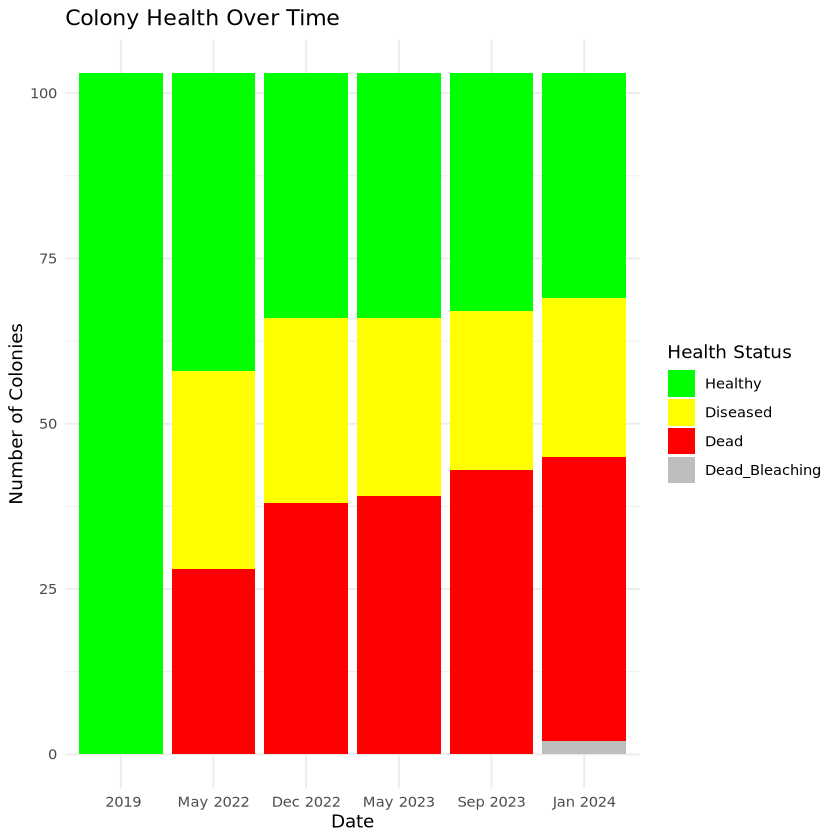

In [76]:
ordered_dates <- unique(colony_data_long$Date)
ordered_dates <- ordered_dates[order(as.Date(ordered_dates, format = "%Y-%b"))]

ggplot(colony_data_long, aes(x = factor(Date, levels = ordered_dates), fill = factor(HealthStatus, levels = c("Healthy", "Diseased", "Dead", "Dead_Bleaching")))) +
  geom_bar(position = "stack") +
  labs(title = "Colony Health Over Time",
       x = "Date",
       y = "Number of Colonies",
       fill = "Health Status") +
  scale_fill_manual(values = c("Healthy" = "green", "Diseased" = "yellow", "Dead" = "red", "Dead_Bleaching" = "gray"), drop = FALSE) +
  theme_minimal()


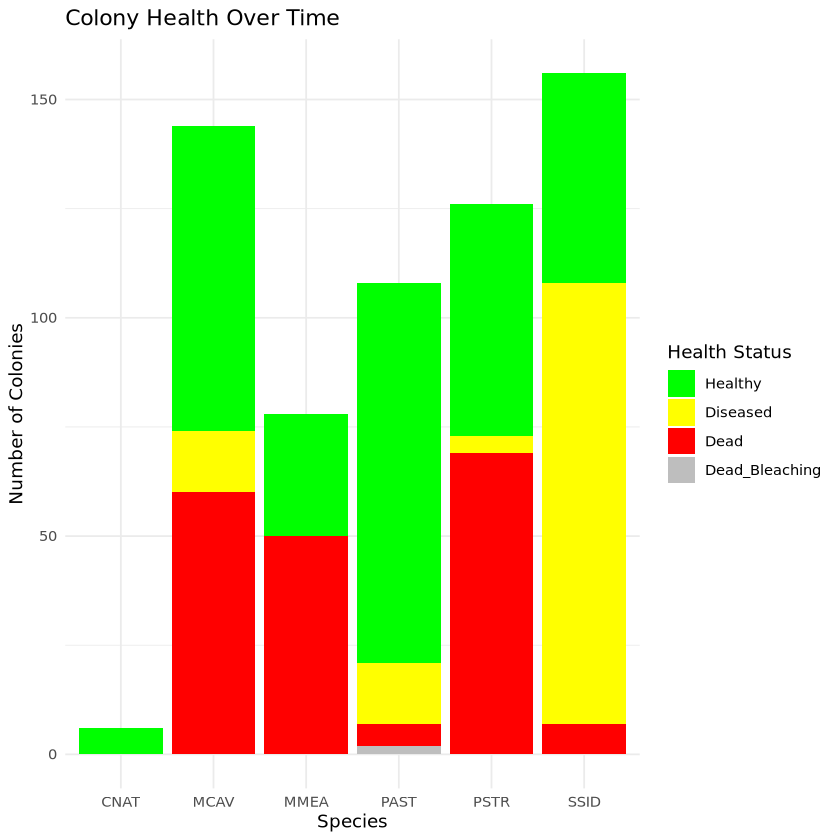

In [79]:
ordered_dates <- unique(colony_data_long$Date)
ordered_dates <- ordered_dates[order(as.Date(ordered_dates, format = "%Y-%b"))]

ggplot(colony_data_long, aes(x = Species, fill = factor(HealthStatus, levels = c("Healthy", "Diseased", "Dead", "Dead_Bleaching")))) +
  geom_bar(position = "stack") +
  labs(title = "Colony Health Over Time",
       x = "Species",
       y = "Number of Colonies",
       fill = "Health Status") +
  scale_fill_manual(values = c("Healthy" = "green", "Diseased" = "yellow", "Dead" = "red", "Dead_Bleaching" = "gray"), drop = FALSE) +
  theme_minimal()


## Species Disease Tracking

In [65]:
colony_data[,"Year_tagged"]

[1] "2019" "2019" "2019" "2019" "2019" "2019" "2019" "2019" "2019" "2019"
 [11] "2019" "2019" "2019" "2019" "2019" "2019" "2019" "2019" "2019" "2019"
 [21] "2019" "2022" "2022" "2022" "2022" "2022" "2019" "2019" "2019" "2019"
 [31] "2019" "2019" "2019" "2019" "2019" "2019" NA     NA     NA     NA    
 [41] NA     "2019" "2019" "2019" "2019" "2019" "2019" "2019" "2019" "2019"
 [51] "2019" "2019" "2019" "2019" "2019" "2019" "2019" "2019" "2019" "2019"
 [61] "2019" "2019" "2019" "2019" "2019" "2019" "2022" "2022" "2022" "2022"
 [71] "2022" "2019" "2019" "2019" "2019" "2019" "2019" "2019" "2019" "2019"
 [81] "2019" "2019" "2019" "2019" "2019" "2019" "2019" "2019" "2019" "2019"
 [91] "2019" "2019" "2019" "2019" "2019" "2019" "2019" "2019" "2019" "2019"
[101] "2019" "2019" "2019" "2019" "2019" "2019" "2019" "2019" "2019" "2019"
[111] "2019" "2019" "2019" "2019" "2019" "2019" "2019" "2019" "2022" "2022"
[121] "2022" "2022" "2022" "2022" "2022" "2022" "2022" "2022" "2022" "2022"
[131] "2019" "2019" "2019" "2022" "2022" "2022" "2022" "2022" "2022" "2022"
[141] "2022" "2022" "2022" "2022" "2022" "2022" "2022" "2022" "2022" "2024"
[151] "2024" "2024" "2024" "2024" "2024" "2024" "2024" "2024" "2024" "2024"
[161] "2024" "2024" "2024" "2024" "2024" "2024" "2024" "2024" "2024" "2024"
[171] "2024" "2024" "2024" "2024" "2024" "2024" "2024" "2024" "2024" "2024"
[181] "2024" "2024" "2024" "2024" "2024" "2024"

In [66]:
# look at na's 
colony_data[(is.na(colony_data["Year_tagged"])),]
# i don't know what to do with them right now so I'm going to remove them 

,X,Date_InitialTag,Transect,TransectNum,OldTagNuim,NewTagNum,Species,Meter,Meters_90,Direction,⋯,MaxDiameter,Height,Date_DocumentedDisease,Date_DocumentedMortality,Notes_May2022,Sept_2023,Nov_2023,Dec_2023,Jan_2024,Year_tagged
,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,⋯,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
37,NA,,SR30N,2,NA,28,PSTR,15.6,1.2,right,⋯,37,25,12/4/22,9/26/23,,Dead,NA,NA,,NA
38,NA,,SR30N,2,NA,29,OFAV,16.0,1.1,right,⋯,40,40,Healthy,Healthy,"50% Bleach, 100% Pale",,Not Visited,Not Visited,,NA
39,NA,,SR30N,2,NA,30,OANN,21.6,4.2,left,⋯,65,50,12/4/22,Diseased,,,Not Visited,Not Visited,,NA
40,NA,,SR30N,2,NA,31,DLAB,23.0,2.7,left,⋯,39,18,Healthy,Healthy,,,Not Visited,Not Visited,,NA
41,NA,,SR30N,2,NA,32,PSTR,5.0,5.0,right,⋯,20,18,Healthy,Healthy,,100%Pale,Not Visited,Not Visited,,NA


In [67]:
#remove colonies with 'na' in year_tagged
#colony_data <- drop_na(colony_data,"Year_tagged")
# remove colonies tagged in 2024 
colony_no2024 <- subset(colony_data, Year_tagged!=2024) 

In [71]:
#filter for disease in 2022
disease_2022_count <- colony_no2024 %>%
  filter(grepl("\\d{1,2}/\\d{1,2}/22", Date_DocumentedDisease))

#filter for death in 2022
death_2022_count <- colony_no2024 %>%
  filter(grepl("\\d{1,2}/\\d{1,2}/22", Date_DocumentedMortality)) 
percent_disease <- (nrow(disease_2022_count)/nrow(colony_no2024))*100
percent_mortality <- (nrow(death_2022_count)/nrow(colony_no2024))*100

cat("Percent of colonies that got diseased in 2022:", percent_disease)
cat("
Number of colonies that died in 2022:", percent_mortality)
cat("
Total percentage of colonies affected by sctld", percent_disease+percent_mortality)

Percent of colonies that got diseased in 2022: 29.86111
Number of colonies that died in 2022: 26.38889
Total number of colonies affected by sctld 56.25

In [31]:
#Goal: calculate % of mcav that got disease from 2019 to 2022

In [34]:
# sort for mcav only 
colony_mcav <- subset(colony_no2024, Species=="MCAV") 

In [58]:
#filter for disease in 2022
disease_mcav2022_count <- colony_mcav %>%
  filter(grepl("\\d{1,2}/\\d{1,2}/22", Date_DocumentedDisease))

death_mcav2022_count <- colony_mcav %>%
  filter(grepl("\\d{1,2}/\\d{1,2}/22", Date_DocumentedMortality)) 

cat("Percent of mcav colonies that got diseased in 2022:", (nrow(disease_mcav2022_count)/nrow(colony_mcav))*100)
cat("
Number of mcav colonies that died in 2022:", (nrow(death_mcav2022_count)/nrow(colony_mcav))*100)
#nrow(colony_mcav)

Percent of mcav colonies that got diseased in 2022: 32.25806
Number of mcav colonies that died in 2022: 38.70968

In [ ]:
### STOP HERE

In [ ]:
colonies_2019 <- colonies_2019 %>%
  mutate("2019" = "Healthy")

In [ ]:
#establish pattern that selects colonies that got disease in May 2022
may_pattern <- grepl("5/\\d{1,2}/22", colonies_2019$Date_DocumentedDisease, fixed = FALSE)
may_dead_pattern <- grepl("5/\\d{1,2}/22", colonies_2019$Date_DocumentedMortality, fixed = FALSE)

In [ ]:
# create column for 2022
colonies_2019_may2022 <- colonies_2019 %>%
  mutate(May2022 =
         case_when(
             may_dead_pattern ~ "Dead",
             may_pattern ~ "Diseased",
             grepl("Healthy", Date_DocumentedDisease)  ~ "Healthy",
             grepl("Unknown", Date_DocumentedDisease) ~ "Unknown",
             TRUE ~ "Healthy")  # Add "Healthy" for any other case
           )


In [ ]:
# Remove rows where both Date_DocumentedDisease and Date_DocumentedMortality are NA
colonies_2019_may2022_delete <- colonies_2019_may2022 %>%
  filter(!(is.na(Date_DocumentedDisease) & is.na(Date_DocumentedMortality)))
nrow(colonies_2019_may2022_delete)
tail(colonies_2019_may2022_delete)

In [ ]:
#establish pattern that selects colonies that got disease in Dec 2022
dec_pattern <- grepl("12/\\d{1,2}/22", colonies_2019_may2022_delete$Date_DocumentedDisease, fixed = FALSE)
dec_dead_pattern <- grepl("12/\\d{1,2}/22", colonies_2019_may2022_delete$Date_DocumentedMortality, fixed = FALSE)
# just looking at how many there are 
sum(dec_pattern)
sum(dec_dead_pattern)

In [ ]:
colonies_2019_2022 <- colonies_2019_may2022_delete %>%
  mutate(Dec2022 =
           case_when(
             dec_dead_pattern ~ "Dead",
               dec_pattern ~ "Diseased",
             grepl("Healthy", Date_DocumentedDisease) ~ "Healthy",
             grepl("Diseased", Date_DocumentedMortality) ~ "Diseased",
             TRUE ~ as.character(May2022)  # Use May2022 when the date doesn't match the pattern
           )
         )
         
head(colonies_2019_2022[,15:25])